# Capstone Project: Airbnb Prediciting Prices 
____

In [295]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.model_selection import cross_val_predict, cross_val_score

import pickle

In [296]:
# Reading dataset
listing = pd.read_csv('../data/listings_model.csv')

In [297]:
listing.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words',
       'amenities_count'],
      dtype='object')

# 3. Pre-Processing Data 
____

Check Distribution Data 
Check Outliers
Visualizations:
    - Barcharts by accomodation type
    - Scatter plot price acomodation (type accomodation legend) (?)
    - Map location lat/log (Folium) (?)
    - Time/price (?)     


In [298]:
listing.shape

(22183, 24)

In [299]:
listing['room_type'].value_counts()

Entire home/apt    11942
Private room        9843
Shared room          336
Hotel room            62
Name: room_type, dtype: int64

In [300]:
listing[listing['room_type']=='Private room'].loc[0]

host_is_superhost                                                               0
host_verifications                                             ['email', 'phone']
host_has_profile_pic                                                            1
host_identity_verified                                                          1
neighbourhood_cleansed                                                 kensington
neighbourhood_group_cleansed                                             Brooklyn
latitude                                                                 40.64529
longitude                                                               -73.97238
room_type                                                            Private room
accommodates                                                                    2
bedrooms                                                                      1.0
beds                                                                          1.0
price           

In [301]:
df  = listing.copy()
# Running model only on Private room
#df = listing[listing['room_type']=='Private room']

In [302]:
df.columns

Index(['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'bathrooms_type', 'bathrooms_nbr',
       'neigh_price_sqft', 'description_count', 'description_words',
       'amenities_count'],
      dtype='object')

In [303]:
df.drop( columns=['host_verifications', 'neighbourhood_group_cleansed',
                'latitude', 'longitude', 'description_words', 'description_count','number_of_reviews'], 
         inplace=True)

In [304]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'amenities_count'],
      dtype='object')

In [305]:
df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft,amenities_count
0,0,1,1,kensington,Private room,2,1.0,1.0,299.0,30,730,4.89,0,shared,1.0,2.77,557
1,1,1,1,bedford-stuyvesant,Private room,2,1.0,1.0,60.0,30,730,4.52,0,private,0.0,2.83,77
2,0,1,1,sunset park,Entire home/apt,4,2.0,2.0,275.0,21,1125,5.00,0,private,1.5,2.31,386
3,1,1,1,greenpoint,Hotel room,2,1.0,1.0,308.0,2,365,4.90,0,private,1.0,3.83,432
4,0,1,1,east village,Private room,2,1.0,2.0,55.0,2,60,4.34,0,shared,1.5,5.71,266


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22183 entries, 0 to 22182
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       22183 non-null  int64  
 1   host_has_profile_pic    22183 non-null  int64  
 2   host_identity_verified  22183 non-null  int64  
 3   neighbourhood_cleansed  22183 non-null  object 
 4   room_type               22183 non-null  object 
 5   accommodates            22183 non-null  int64  
 6   bedrooms                22183 non-null  float64
 7   beds                    22183 non-null  float64
 8   price                   22183 non-null  float64
 9   minimum_nights          22183 non-null  int64  
 10  maximum_nights          22183 non-null  int64  
 11  review_scores_rating    22183 non-null  float64
 12  instant_bookable        22183 non-null  int64  
 13  bathrooms_type          22183 non-null  object 
 14  bathrooms_nbr           22183 non-null

## 3.1. Dummifying

In [307]:
df.columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'amenities_count'],
      dtype='object')

In [308]:
# Setting category columns to Dummify
col_dummies = ['neighbourhood_cleansed', 'bathrooms_type', 'room_type'] #'neighbourhood_group_cleansed',

In [309]:
df.shape

(22183, 17)

In [310]:
df = pd.get_dummies(df, prefix_sep="__", columns = col_dummies, drop_first = True);

In [311]:
df.shape

(22183, 171)

In [312]:
#df.to_csv('../data/listing_preprocess.csv', index=False)

## 3.2. Creating X and y 

In [313]:
X = df.drop(columns='price')
y = np.log(df['price'])
print(X.shape)
print(y.shape)

(22183, 170)
(22183,)


In [314]:
X_train, X_test, y_train, y_test = train_test_split(
        X,  
        y,
        test_size = 0.3,     
        random_state = 42
 )

In [315]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15528, 170), (6655, 170), (15528,), (6655,))

## 3.3. Scaling Data

In [316]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# 4. Machine Learning Models
____

## 4.1. Baseline Model

In [317]:
#Setting a Baseline and getting its Score
baseline_model = [y_train.mean()] * len(y_test)
r2_score(y_test, baseline_model)

-0.00019758509399592228

### Fitting Regression Model
___

In [318]:
#Fitting Model
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression()

In [319]:
#Cross Vaditadion Score
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()
# -3.3924557963554062e+25

-2.0602804326459864e+26

In [320]:
# Calcuate residual
lr_y_preds = np.exp(lr.predict(X_train_sc))
residuals = y_train - lr_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lr_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lr_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lr_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lr_y_preds)}')
#MAE: 129.81014920371308
#MSE: 21210.975157781893
#RMSE: 145.63988175558882
#R2: -55534.009329901186

MAE: 130.19554519835535
MSE: 21499.738854603707
RMSE: 146.62789248503748
R2: -56122.605754736454


In [321]:
#Comparing scores
print(f'Train set: {lr.score(X_train_sc, y_train)}')
print(f'Test set: {lr.score(X_test_sc, y_test)}')
print(f'Diference (train/test): {lr.score(X_train_sc, y_train)-lr.score(X_test_sc, y_test)}')

#Train set: 0.6306346195368164
#Test set: -3.790486871672232e+20
#Diference (train/test): 3.790486871672232e+20


Train set: 0.6530699363889738
Test set: -9.38202132822668e+20
Diference (train/test): 9.38202132822668e+20


In [322]:
# Creating a list of coeficients
list_coef = list(zip( lr.coef_, X.columns))

In [323]:
# Turn it into a data frame
pd.DataFrame(lr.coef_, index = X.columns, columns = ['Coefficient'])

,Coefficient
host_is_superhost,2.997592e-02
host_has_profile_pic,-1.041135e-02
host_identity_verified,4.585339e-03
accommodates,1.336528e-01
bedrooms,6.197035e-02
...,...
neighbourhood_cleansed__woodside,6.363374e+09
bathrooms_type__shared,-9.187674e-02
room_type__Hotel room,2.021904e-02
room_type__Private room,-1.817503e-01


### Residuals
___

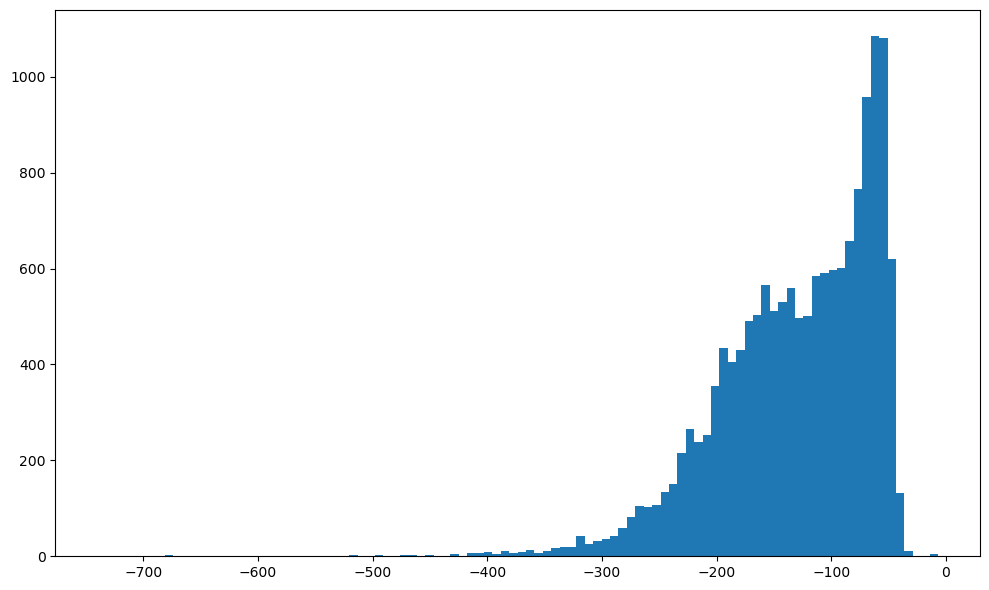

In [324]:
# Normality assumption 
plt.figure(figsize = (10, 6))
plt.hist(residuals, bins = 100);
plt.tight_layout()

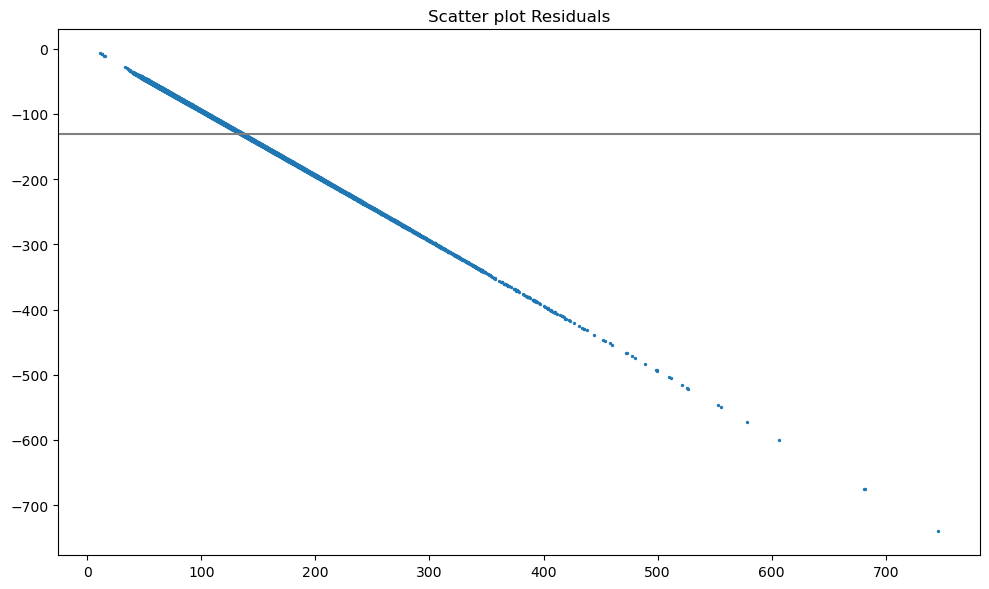

In [325]:
# Normality assumption 
plt.figure(figsize = (10,6))
plt.title("Scatter plot Residuals")
#Ploting Residuals - Scatter Plotf SLR Model 
plt.scatter(lr_y_preds, residuals,s=2);
plt.axhline(residuals.mean(), color='grey');
plt.tight_layout()

## 4.2. Lasso Regularization

In [326]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(X_train_sc, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [327]:
# Here is the optimal value of alpha
print("Best Value of alpha: ",lasso_cv.alpha_)

# Scores on Train a
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))

Best Value of alpha:  0.0016297508346206436
Lasson Train Score:  0.6520600275067465
Lasso Test Score 0.6362987791911574


In [328]:
# Calcuate residual
lasso_y_preds = np.exp(lasso_cv.predict(X_train_sc))
residuals = y_train - lasso_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, lasso_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, lasso_y_preds)}')

MAE: 129.83102028823217
MSE: 21281.538674665477
RMSE: 145.88193402428374
R2: -55553.00902813047


## 4.3. Ridge Regularization

In [329]:
# Instantiate.
ridge = Ridge(alpha = 100)

# Fit.
ridge.fit(X_train_sc, y_train)

# Evaluate model using R2.
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')

Training Score: 0.6530037431020282
Testing Score: 0.6348043330324313


In [330]:
# Calcuate residual
ridge_y_preds = np.exp(ridge.predict(X_train_sc))
residuals = y_train - ridge_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, ridge_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, ridge_y_preds)}')

MAE: 130.09658561109774
MSE: 21446.755996684144
RMSE: 146.4471098952934
R2: -55984.29760830983


## 4.4. KNNeighbors Regressor


In [331]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# define the grid search
knn_grid= GridSearchCV(KNeighborsRegressor(), param_grid=knn_params, cv=5, verbose = -1)
knn_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2]},
             verbose=-1)

In [332]:
knn_grid.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'p': 1}

In [333]:
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')

# Calcuate residual
knn_grid_y_preds = np.exp(knn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - knn_grid_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_grid_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_grid_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_grid_y_preds)}')

Training Score: 0.7164422592160897
Testing Score: 0.6355191089610889
MAE: 128.5923733042665
MSE: 20906.81929727949
RMSE: 144.59190605728762
R2: -54574.82958384535


In [334]:
knn = KNeighborsRegressor(n_neighbors=5, p=2)
knn.fit(X_train_sc, y_train)

print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')

# Calcuate residual
knn_y_preds = np.exp(knn.predict(X_train_sc))
residuals = y_train - knn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, knn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, knn_y_preds)}')

Training Score: 0.7509683365671211
Testing Score: 0.6117014850455137
MAE: 130.64698067023676
MSE: 21935.89256793233
RMSE: 148.10770597079792
R2: -57261.15535391349


## 4.5. CART 

In [335]:
# Instantiate model with:
# - a maximum depth of .
# - at least  samples required in order to split an internal node.
# - at least  samples in each leaf node.
# - a cost complexity of 0.01.
# - random state of 42.

dt_params = {
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]
}

dt_grid = GridSearchCV(
                    estimator = DecisionTreeRegressor(random_state=42),
                    param_grid = dt_params,
                    cv = 5,
                    verbose = 1)

# GridSearch!
dt_grid.fit(X_train_sc, y_train)

# What is our best decision tree?
print("Best Estimator: ", dt_grid.best_estimator_)

# What was the cross-validated score of the above decision tree?
print("Best Score: ", dt_grid.best_score_)

# Evaluate model.
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Estimator:  DecisionTreeRegressor(ccp_alpha=0.001, max_depth=7, min_samples_leaf=2,
                      min_samples_split=5, random_state=42)
Best Score:  0.6147586212188956
Score on training set: 0.6244990075710446
Score on testing set: 0.6039309359709841


In [336]:
# Calcuate residual
dt_y_preds = np.exp(dt_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - dt_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, dt_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, dt_y_preds)}')

MAE: 129.0757529146791
MSE: 20488.669113795015
RMSE: 143.13863599250558
R2: -53483.27697463177


## 4.6. Random Forest

In [337]:
# Taking 47 min to run
# Gridsearch Parameters
rf_params = {
    'n_estimators': [200, 250, 300, 400],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_depth' : [None, 3, 4, 5, 6],
    'n_jobs': [-1]
}
# Setting Gridsearch
rf_grid = GridSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = rf_params, 
    cv = 5
)
# Fitting Model
rf_grid.fit(X_train_sc, y_train)

# Printing Outputs
print(f'Best Score : {rf_grid.best_score_}')
print(f'Best Parameters: {rf_grid.best_params_}') 
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')

Best Score : 0.6995591924501736
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 400, 'n_jobs': -1}
Score on training set: 0.9249446726152587
Score on test set: 0.6821162256882363


In [338]:
# Calcuate residual
rf_y_preds = np.exp(rf_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - rf_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, rf_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, rf_y_preds)}')

MAE: 133.28891942437932
MSE: 23166.484894361787
RMSE: 152.20540363062602
R2: -60473.53291070144


## 4.7. Neural Network

In [339]:
def model_fn(h1_neurons = 32, h2_neurons=32, drop = 0.5):
  
  print(f'h1: {h1_neurons}, h2: {h2_neurons}, drop: {drop}')
  
  inputs = Input(shape = (X_train_sc.shape[1],))
  
  h1 = Dense(h1_neurons, activation = 'relu')(inputs)
  d1 = Dropout(drop)(h1)
  
  h2 = Dense(h2_neurons, activation = 'relu')(d1)
  out = Dense(1, activation = None)(h2)

  model = Model(inputs = inputs, outputs = out)

  model.compile(loss = 'mse',
                optimizer = 'adam', 
                metrics='acc')
  
  return model

In [340]:
# kind of like when lr = LinearRegression()
nn = KerasRegressor(build_fn = model_fn, batch_size = 256, verbose = 0)

In [341]:
params = {
    'epochs': [100],
    'h1_neurons': [16, 64, 128],
    'h2_neurons': [64, 128],
    'drop':[0.1,0.25, 0.5]
}

In [342]:
# 19 min to run
nn_grid = GridSearchCV(nn, param_grid = params, cv = 3)
nn_grid.fit(X_train_sc, y_train)

h1: 16, h2: 64, drop: 0.1


2022-11-13 21:43:33.822884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:43:52.614067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-13 21:43:53.293430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:44:10.272716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.1


2022-11-13 21:44:10.643740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:44:28.205115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 21:44:28.705368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:44:46.920913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 21:44:47.458541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:45:04.700692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 21:45:04.997672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:45:22.074397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 21:45:22.379655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:45:39.800866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 21:45:40.660503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:45:59.068044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.1


2022-11-13 21:45:59.397329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:46:16.822683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 21:46:17.125948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:46:34.385285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 21:46:34.760329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:46:52.380575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.1


2022-11-13 21:46:52.712029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:47:10.218140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 21:47:10.557951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:47:27.954793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 21:47:28.257856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:47:45.912822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.1


2022-11-13 21:47:46.852762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:48:05.493953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 21:48:05.845003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:48:23.444398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 21:48:23.745531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:48:41.203132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.1


2022-11-13 21:48:41.499131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:48:59.207510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 21:48:59.507179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:49:16.508872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 21:49:16.821076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:49:34.280502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.25


2022-11-13 21:49:35.172797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:49:53.042593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 21:49:53.454836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:50:10.626999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 21:50:10.926084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:50:28.101873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.25


2022-11-13 21:50:28.423775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:50:45.823961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 21:50:46.160648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:51:03.640865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 21:51:03.962770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:51:21.291482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.25


2022-11-13 21:51:21.660944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:51:38.892378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 21:51:39.830686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:51:57.999055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 21:51:58.312223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:52:15.557691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.25


2022-11-13 21:52:15.846004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:52:33.850253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 21:52:34.244930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:52:52.282986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 21:52:52.667386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:53:10.790311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.25


2022-11-13 21:53:11.129024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:53:28.349809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 21:53:29.284432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:53:47.413538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 21:53:47.749001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:54:05.441384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.25


2022-11-13 21:54:05.830253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:54:23.227326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 21:54:23.554744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:54:40.777184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 21:54:41.096435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:54:58.791717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 64, drop: 0.5


2022-11-13 21:54:59.155075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:55:16.125913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 21:55:16.430016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:55:33.758490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 21:55:34.655484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:55:52.938831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.5


2022-11-13 21:55:53.454443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:56:10.729201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 21:56:11.071397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:56:28.296698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 21:56:28.610545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:56:46.311777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 64, drop: 0.5


2022-11-13 21:56:46.676562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:57:04.274969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 21:57:04.584215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:57:21.744129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 21:57:22.048392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:57:39.917633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 64, h2: 128, drop: 0.5


2022-11-13 21:57:40.235346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:57:58.094363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 21:57:58.472508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:58:16.074805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 21:58:16.406545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:58:33.828711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 64, drop: 0.5


2022-11-13 21:58:34.256995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:58:51.384272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 21:58:51.751051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:59:09.208686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 21:59:09.552233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:59:26.839080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 128, h2: 128, drop: 0.5


2022-11-13 21:59:27.780644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-13 21:59:46.248832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


h1: 16, h2: 128, drop: 0.1


2022-11-13 21:59:46.581229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x280db85e0>,
             param_grid={'drop': [0.1, 0.25, 0.5], 'epochs': [100],
                         'h1_neurons': [16, 64, 128], 'h2_neurons': [64, 128]})

In [343]:
print(f'Best Score: {nn_grid.best_score_}')
print(f'Best parameters: {nn_grid.best_params_}')

Best Score: -0.14839634795983633
Best parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 128}


In [344]:
# Printing Outputs
print(f'Best Score : {nn_grid.best_score_}')
print(f'Best Parameters: {nn_grid.best_params_}') 
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')

Best Score : -0.14839634795983633
Best Parameters: {'drop': 0.1, 'epochs': 100, 'h1_neurons': 16, 'h2_neurons': 128}


2022-11-13 22:00:12.256331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Score on training set: -0.11741849780082703
Score on test set: -0.13535384833812714


In [345]:
# Calculate residual
nn_y_preds = np.exp(nn_grid.best_estimator_.predict(X_train_sc))
residuals = y_train - nn_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, nn_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, nn_y_preds)}')

MAE: 116.00883173216236
MSE: 16579.336292912318
RMSE: 128.76077156072154
R2: -43278.229579077415


2022-11-13 22:00:12.871212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## 4.8. Stacking 


Getting the predictions from models (level 1) to use as features for an another model (level 2)

In [346]:
X_pred_train = pd.DataFrame(index = X_train.index)

X_pred_train['model_rf'] = rf_grid.best_estimator_.predict(X_train_sc) # Radom Forest Model Predictions
X_pred_train['model_dt'] = dt_grid.best_estimator_.predict(X_train_sc) # Decision Trees Model Predictions
X_pred_train['model_ridge'] = ridge.predict(X_train_sc) # Linear Regression Ridge Regulatization Predictions
X_pred_train

,model_rf,model_dt,model_ridge
8131,4.999765,5.441017,4.735192
1276,4.659306,4.689340,4.757615
13904,3.872742,3.919718,4.421316
6259,4.613629,4.962515,4.781268
7348,3.907352,4.464705,4.447545
...,...,...,...
11964,4.916960,5.482325,5.066648
21575,5.222119,5.206480,5.214465
5390,4.665704,4.689340,4.697422
860,5.395705,5.441017,5.327586


In [347]:
stacked_model = LinearRegression()
cross_val_score(stacked_model, X_train_sc, y_train).mean()

-2.0602804326459864e+26

In [348]:
# Fit
stacked_model.fit(X_pred_train, y_train)

LinearRegression()

In [349]:
# Train score
stacked_model.score(X_pred_train, y_train)

0.9563823868966741

In [350]:
X_pred_test = pd.DataFrame(index = X_test.index)

X_pred_test['model_rf'] = rf_grid.best_estimator_.predict(X_test_sc) # Radom Forest Model Predictions
X_pred_test['model_dt'] = dt_grid.best_estimator_.predict(X_test_sc)# Decision Trees Model Predictions
X_pred_test['model_ridge'] = ridge.predict(X_test_sc)# Linear Regression Ridge Regulatization Predictions
X_pred_test

,model_rf,model_dt,model_ridge
563,5.222202,5.072247,4.657401
1383,5.279442,5.072247,5.225477
2404,4.114361,4.348723,4.270332
16430,5.248811,5.206480,5.357268
13160,4.101124,4.348723,3.797021
...,...,...,...
7003,4.875704,5.247404,5.048413
16719,4.904879,4.687038,4.841966
3788,5.321763,5.425551,5.210584
9068,5.497169,5.206480,5.306203


In [351]:
# Test score
stacked_model.score(X_pred_test, y_test)

0.644634398700457

In [352]:
# Calcuate residual
stacked_y_preds = np.exp(stacked_model.predict(X_pred_train))
residuals = y_train - stacked_y_preds

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, stacked_y_preds)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, stacked_y_preds)}')

MAE: 137.6139269973164
MSE: 26156.781643685743
RMSE: 161.7305835137119
R2: -68279.49915911433


## 4.9. Stacked Model ElasticNet

In [353]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio - the amount of L1 vs L2 penalty. 
# An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.
enet_ratio = 0.01

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_pred_train, y_train)

# Evaluate model.
print(enet_model.score(X_pred_train, y_train))
print(enet_model.score(X_pred_test, y_test))

0.6817653139539778
0.5883604135562659


In [354]:
# Calcuate residual
enet_model_preds_train = np.exp(enet_model.predict(X_pred_train))
residuals = y_train - enet_model_preds_train

# Metrics
print(f'MAE: {metrics.mean_absolute_error(y_train, enet_model_preds_train)}')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'R2: {metrics.r2_score(y_train, enet_model_preds_train)}')

MAE: 120.944002435975
MSE: 16178.736214335508
RMSE: 127.19566114587207
R2: -42232.49032487493


## 4.10. Models Benchmarks
_________________

In [355]:
print(f' ### Linear Regression')
print(f'Training Score: {knn.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f' ### Lasso Regularization')
print("Lasson Train Score: ", lasso_cv.score(X_train_sc, y_train))
print("Lasso Test Score", lasso_cv.score(X_test_sc, y_test))
print(f'MSE: {metrics.mean_squared_error(y_train, lasso_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, lasso_y_preds, squared = False)}')
print(f' ### Ridge Regularization ')
print(f'Training Score: {ridge.score(X_train_sc, y_train)}')
print(f'Testing Score: {ridge.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, ridge_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, ridge_y_preds, squared = False)}')
print(f' ### KNearestNeighborhood GridSearch')
print(f'Training Score: {knn_grid.score(X_train_sc, y_train)}')
print(f'Testing Score: {knn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, knn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, knn_y_preds, squared = False)}')
print(f' ### DecisionTrees GridSearch')
print(f'Score on training set: {dt_grid.score(X_train_sc, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, dt_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, dt_y_preds, squared = False)}')
print(f' ### RainForest GridSearch')
print(f'Score on training set: {rf_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {rf_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, rf_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, rf_y_preds, squared = False)}')
print(f' ### NeuralNetworks GridSearch')
print(f'Score on training set: {nn_grid.score(X_train_sc, y_train)}')
print(f'Score on test set: {nn_grid.score(X_test_sc, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, nn_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, nn_y_preds, squared = False)}')
print(f' ### Stacking Model')
print(f'Train score:{stacked_model.score(X_pred_train, y_train)}')
print(f'Test score:{stacked_model.score(X_pred_test, y_test)}')
print(f'MSE: {metrics.mean_squared_error(y_train, stacked_y_preds)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, stacked_y_preds, squared = False)}')
print(f' ### ElasticNet Stacking Model')
print(f'MSE: {metrics.mean_squared_error(y_train, enet_model_preds_train)}')
print(f'RMSE: {metrics.mean_squared_error(y_train, enet_model_preds_train, squared = False)}')
print(f'Training Score:{enet_model.score(X_pred_train, y_train)}')
print(f'Testining Score:{enet_model.score(X_pred_test, y_test)}')

 ### Linear Regression
Training Score: 0.7509683365671211
Testing Score: 0.6117014850455137
MSE: 21935.89256793233
RMSE: 148.10770597079792
 ### Lasso Regularization
Lasson Train Score:  0.6520600275067465
Lasso Test Score 0.6362987791911574
MSE: 21281.538674665477
RMSE: 145.88193402428374
 ### Ridge Regularization 
Training Score: 0.6530037431020282
Testing Score: 0.6348043330324313
MSE: 21446.755996684144
RMSE: 146.4471098952934
 ### KNearestNeighborhood GridSearch
Training Score: 0.7164422592160897
Testing Score: 0.6355191089610889
MSE: 21935.89256793233
RMSE: 148.10770597079792
 ### DecisionTrees GridSearch
Score on training set: 0.6244990075710446
Score on testing set: 0.6039309359709841
MSE: 20488.669113795015
RMSE: 143.13863599250558
 ### RainForest GridSearch
Score on training set: 0.9249446726152586
Score on test set: 0.6821162256882363
MSE: 23166.484894361787
RMSE: 152.20540363062602
 ### NeuralNetworks GridSearch
Score on training set: -0.11741849780082703
Score on test set:

# 5. Pickling a Model
___

Pickling a model to build a streamlit app.

In [356]:
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid, f)